# H2 VISAS

This notebook explores the dataset of H2 visa applications (https://github.com/BuzzFeedNews/H-2-certification-data#standardized-data). 

The U.S. Department of Labor releases this data as Excel (.XLS) files and BuzzFeed News has been tracking and hosting these datasets on Github. The dataset has data from fiscal year 2000 till 2016, this notebook will only take into account the data from fiscal year 2010 to 2016 (which only goes to March 31st)

There are 2 types of H2 Visas:

* H2-A: Allows foreign agricultural workers with a job offer for seasonal agricultural work in the US (https://www.uscis.gov/working-united-states/temporary-workers/h-2a-temporary-agricultural-workers)

* H2-B: Allows U.S. employers or U.S. agents who meet specific regulatory requirements to bring foreign nationals to the United States to fill temporary nonagricultural jobs (https://www.uscis.gov/working-united-states/temporary-workers/h-2b-temporary-non-agricultural-workers)

**Index:**

1. Load data, first look
2. Filter by fiscal year?
3. Duplicates 
4. Data cleaning (for each column)
5. Feature selection
6. Analysis
    *    6.1 How application status have change over time?
    *    6.2 How have the number of approved workers has changed  over time? and the number of employers?
    *    6.3 Which states request the most visas and how has this changed over time?
    *    6.4 Number of approved Visas per state in 2015 

### 1. Load data, first look

In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import vincent
%matplotlib inline
plt.style.use('fivethirtyeight')

# load data
h2visas_df = pd.read_csv(".\\datasets\\H-2-certification-decisions.csv",
                         low_memory=False)

First, we check the number of columns, the names of these, and we print the first few rows of the data set to get an idea of how it looks like

In [2]:
# shape and column names
print("Number of columns/rows:")
print(h2visas_df.shape)
print("-------------------\nColumns:")
print(h2visas_df.columns)
h2visas_df.head(4)

Number of columns/rows:
(213155, 22)
-------------------
Columns:
Index(['case_no', 'visa_type', 'fy', 'last_event_date', 'case_status',
       'n_requested', 'n_certified', 'is_certified',
       'certification_begin_date', 'certification_end_date', 'job_title',
       'employer_name', 'employer_state', 'employer_city',
       'employer_address_1', 'employer_address_2', 'employer_postal_code',
       'worksite_state', 'worksite_city', 'agent_name', 'organization_flag',
       'is_duplicate'],
      dtype='object')


,case_no,visa_type,fy,last_event_date,case_status,n_requested,n_certified,is_certified,certification_begin_date,certification_end_date,...,employer_state,employer_city,employer_address_1,employer_address_2,employer_postal_code,worksite_state,worksite_city,agent_name,organization_flag,is_duplicate
0,9455254,H-2B,2000,1999-10-01,"DENIED, TEMPORARY",1.0,0,False,NaN,NaN,...,CA,LOS ANGELES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8222219,H-2B,2000,1999-10-04,"CERTIFIED, TEMPORARY",2.0,2,True,NaN,NaN,...,CO,BEAVER CREEK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8222168,H-2B,2000,1999-10-04,"CERTIFIED, TEMPORARY",2.0,2,True,NaN,NaN,...,CO,MT. CRESTED BUTTE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8222169,H-2B,2000,1999-10-04,"CERTIFIED, TEMPORARY",5.0,5,True,NaN,NaN,...,CO,MT. CRESTED BUTTE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Other important features to check are the column types, and the number of missing values. For missing values I'll use a new library that visualizes them, this will allow us to see where the missing values are located.

In [3]:
#column types
print('------ Column types:')
print(h2visas_df.info())

print('\n----------------------------------\n')

# number of nulls per column
print('------ Missing values:')
print(h2visas_df.isnull().sum())

------ Column types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213155 entries, 0 to 213154
Data columns (total 22 columns):
case_no                     213155 non-null object
visa_type                   213155 non-null object
fy                          213155 non-null int64
last_event_date             205686 non-null object
case_status                 213155 non-null object
n_requested                 141512 non-null float64
n_certified                 213155 non-null int64
is_certified                213155 non-null bool
certification_begin_date    155351 non-null object
certification_end_date      155342 non-null object
job_title                   212671 non-null object
employer_name               213133 non-null object
employer_state              213029 non-null object
employer_city               213076 non-null object
employer_address_1          169205 non-null object
employer_address_2          21596 non-null object
employer_postal_code        168879 non-null object
works

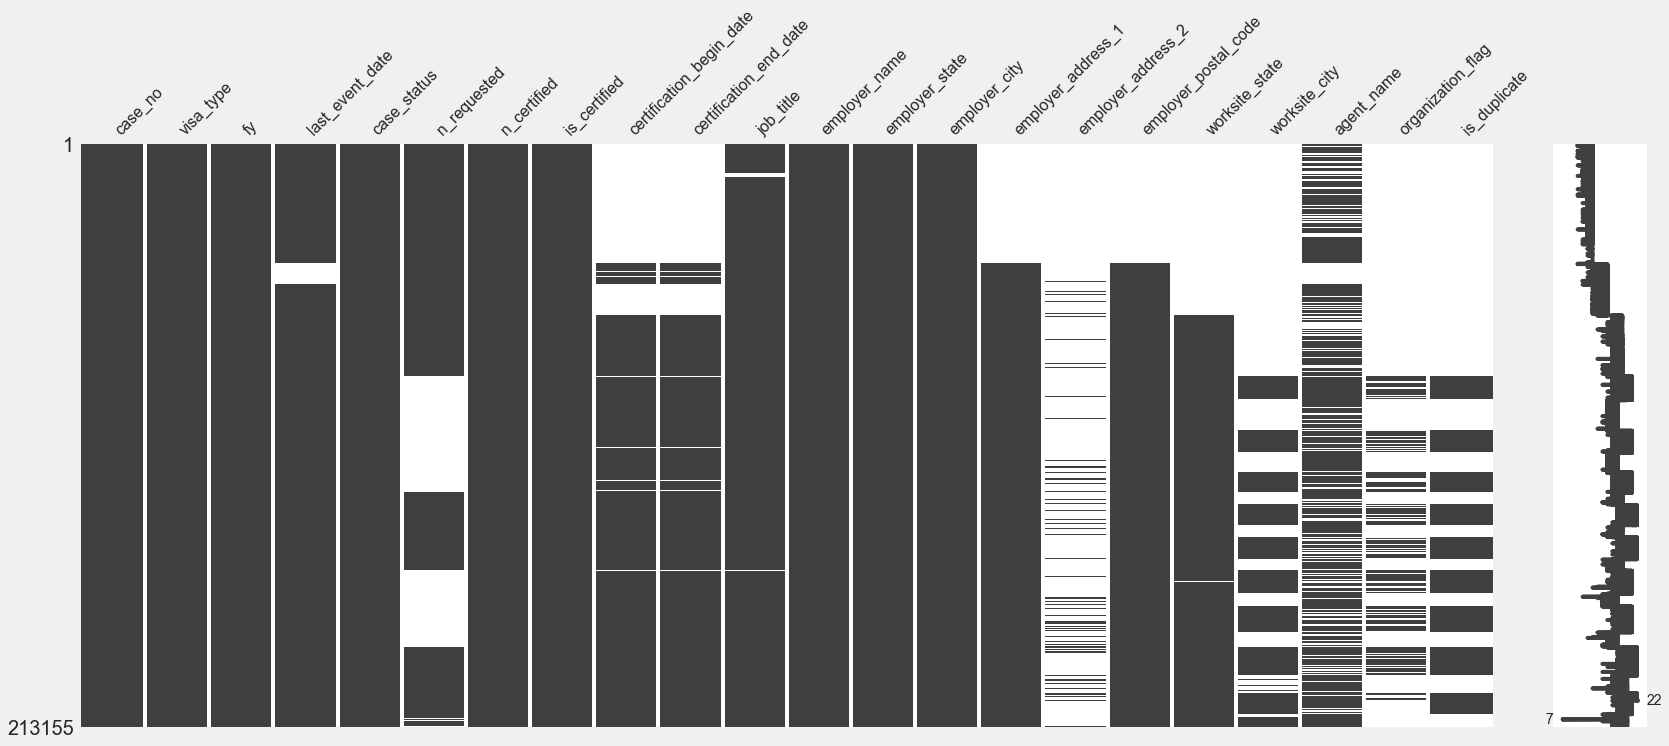

In [4]:
msno.matrix(h2visas_df)

Most `NaN` values are at the beginning of the data set, and we know the rows are sorted by date so analyzing years from 2010 onward will get rid of many missing values. 

To end this part we check how many visas of each kind we have

H-2B    122662
H-2A     90493
Name: visa_type, dtype: int64


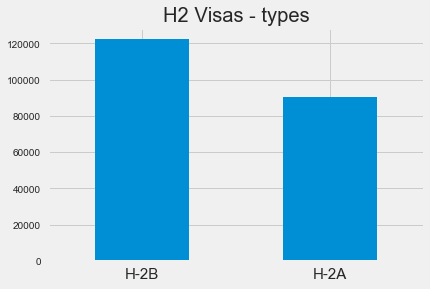

In [5]:
print(h2visas_df.visa_type.value_counts())
h2visas_df.visa_type.value_counts().plot.bar()
plt.title("H2 Visas - types")
plt.xticks(rotation='horizontal', size=15)
plt.show()

As we can see there are more H-2B visas than H-2A visas

### 2. Filter by fiscal year

I'll work from data starting October 1, 2010 to March 31, 2016. Which means fiscal year of 2011 in advance

In [6]:
h2visas_df = h2visas_df[h2visas_df["fy"] >= 2011]

Let's visualize the NaN values and check for types of Visasagain:

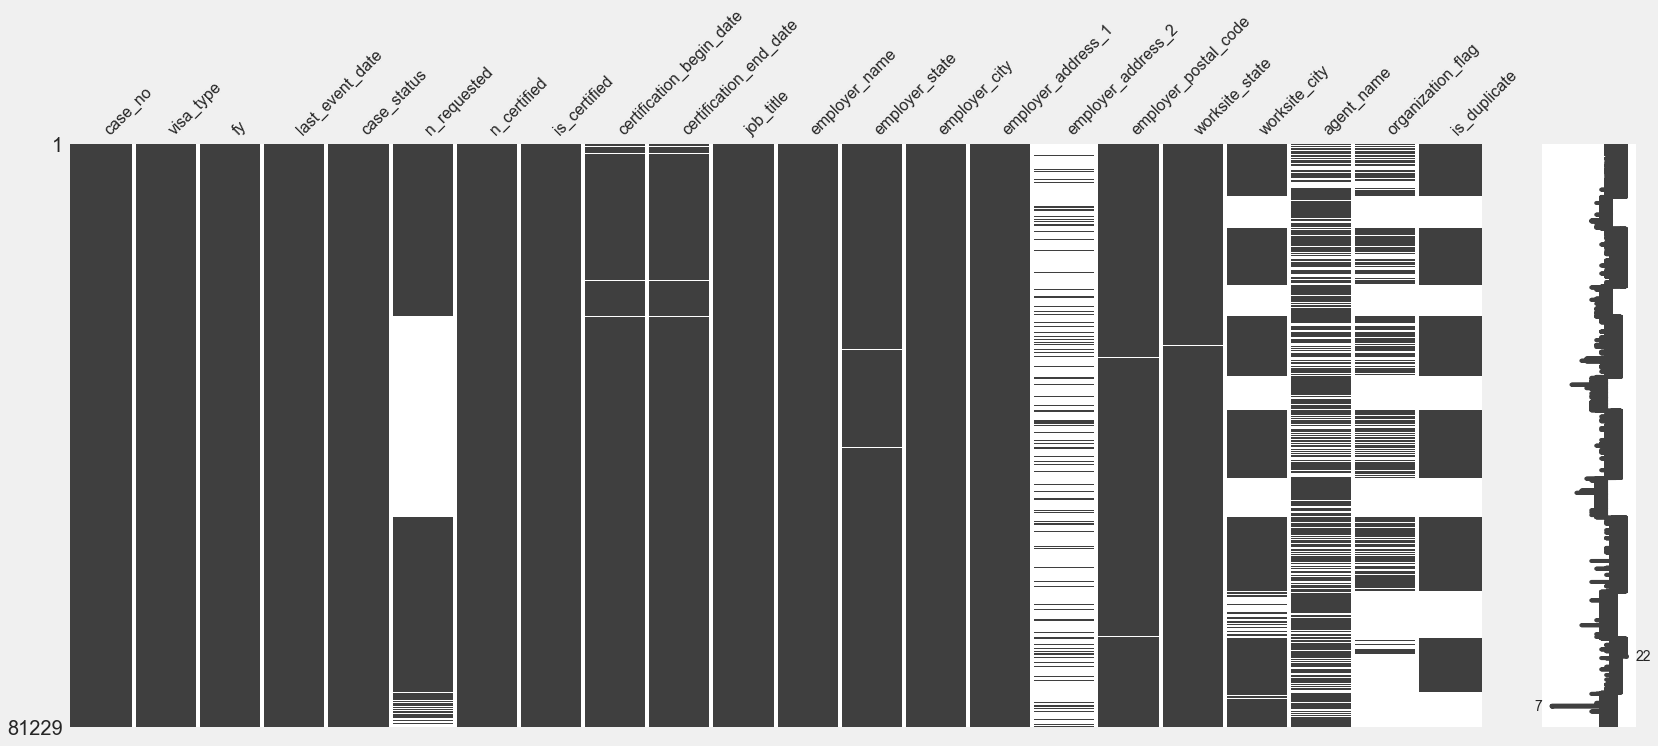

In [7]:
msno.matrix(h2visas_df)

H-2A    51096
H-2B    30133
Name: visa_type, dtype: int64


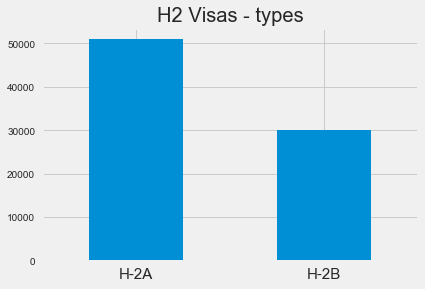

In [8]:
print(h2visas_df.visa_type.value_counts())
h2visas_df.visa_type.value_counts().plot.bar()
plt.title("H2 Visas - types")
plt.xticks(rotation='horizontal', size=15)
plt.show()

### 3. Duplicates

There is a column that tells us if a entry is a duplicate. Let's see if we the dataset comes with any duplicates and to which kind of visa they belong

In [9]:
h2visas_df['visa_type'][h2visas_df['is_duplicate'] == True].value_counts()

H-2A    19314
Name: visa_type, dtype: int64

All duplicates are visas H-2A 

If we examined the data closer we see that 'case_no' also has duplicates for H-2B visas:

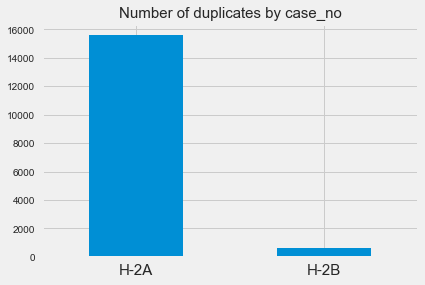


-------------------------
Example of H-2B duplicate:


,case_no,visa_type,fy,last_event_date,case_status,n_requested,n_certified,is_certified,certification_begin_date,certification_end_date,...,employer_state,employer_city,employer_address_1,employer_address_2,employer_postal_code,worksite_state,worksite_city,agent_name,organization_flag,is_duplicate
200324,H-400-15155-885907,H-2B,2015,2015-07-28,CERTIFICATION,14.0,14,True,2015-08-03,2015-11-01,...,NJ,CHESTER,1 ALSTEDE FARMS LANE,"MAILING: PO BOX 278, CHESTER, NJ 07930",07930,NJ,NaN,FEDERATION OF EMPLOYERS AND WORKERS OF AMERICA...,NaN,NaN
208692,H-400-15155-885907,H-2B,2016,2015-10-20,WITHDRAWN,14.0,0,False,2015-08-03,2015-11-01,...,NJ,CHESTER,1 ALSTEDE FARMS LANE,"MAILING: PO BOX 278, CHESTER, NJ 07930",7930.0,NJ,NaN,FEDERATION OF EMPLOYERS AND WORKERS OF AMERICA...,NaN,NaN
208720,H-400-15155-885907,H-2B,2016,2015-10-20,WITHDRAWN,NaN,0,False,2015-08-03,2015-11-01,...,NJ,CHESTER,1 ALSTEDE FARMS LANE,"MAILING: PO BOX 278, CHESTER, NJ 07930",7930,NJ,Chester,FEDERATION OF EMPLOYERS AND WORKERS OF AMERICA...,NaN,NaN


In [10]:
h2visas_df['visa_type'][h2visas_df.duplicated('case_no')].value_counts().plot(kind='bar')
plt.xticks(rotation='horizontal',size=15)
plt.title("Number of duplicates by case_no",size=15)
plt.show()

print("\n-------------------------")
print("Example of H-2B duplicate:")
h2visas_df[h2visas_df['case_no']=='H-400-15155-885907']

This makes sense though, here is the description of the `is_duplicate` field:

*This derived value will be  True  — indicating that this row corresponds a sub-application of a joint employer's "master application" — if (a)  visa_type  is "H-2A", (b) the  organization_flag  is blank, and (c) comes from fiscal year 2008 or later. H-2A data from FY 2006 and FY 2007 do not contain a  organization_flag  field. For these records, and H-2B records,  is_duplicate  will be  null*

Let's get rid of H-2A duplicates and also get rid of H-2B duplicates

In [11]:
# split visas
h2visasA_df = h2visas_df[h2visas_df['visa_type']== 'H-2A']
h2visasB_df = h2visas_df[h2visas_df['visa_type']== 'H-2B']
# delete duplicates
h2visasA_df = h2visasA_df[h2visasA_df['is_duplicate']==True]
h2visasB_df = h2visasB_df.drop_duplicates('case_no','first')
# concatenate 
h2visas_df = pd.concat([h2visasA_df,h2visasB_df])

### 4. Data cleaning (for each column)

### 4.1 visa_type

In [12]:
print('Number of visa type nulls:')
h2visas_df.visa_type.isnull().sum()

Number of visa type nulls:


0

H-2B    29499
H-2A    19314
Name: visa_type, dtype: int64


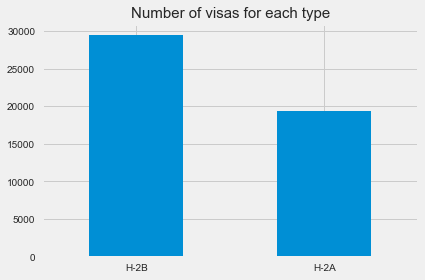

In [13]:
print(h2visas_df["visa_type"].value_counts())
h2visas_df["visa_type"].value_counts().plot(kind='bar')
plt.title("Number of visas for each type", size=15)
plt.xticks(rotation='horizontal')
plt.show()

### 4.2  case status & is_certified
There are many case status but some of them mean the same thing. I will simplify them into 5 different statuses (Cerfified, In_progress, Denied, Expired, and Withdrawn ) 

In [14]:
#case_status counts
h2visas_df["case_status"].value_counts()

CERTIFICATION                                           16969
CERTIFIED                                                8166
CERTIFIED - FULL                                         6119
DETERMINATION ISSUED - CERTIFICATION                     5417
DENIED                                                   3286
PARTIAL CERTIFIED                                        3193
PARTIAL CERTIFICATION                                    2034
WITHDRAWN                                                1796
CERTIFIED - PARTIAL                                      1273
CERTIFICATION EXPIRED                                     320
DETERMINATION ISSUED - PARTIAL CERTIFICATION               95
PARTIAL CERTIFICATION EXPIRED                              75
DETERMINATION ISSUED - CERTIFICATION EXPIRED               49
DETERMINATION ISSUED - WITHDRAWN                            9
DETERMINATION ISSUED - PARTIAL CERTIFICATION EXPIRED        8
DETERMINATION ISSUED - DENIED                               4
Name: ca

In [15]:
Certified = ['CERTIFIED - FULL','CERTIFIED','CERTIFIED, TEMPORARY',
             'DETERMINATION ISSUED - CERTIFICATION','CERTIFICATION',]
Partial = ['PARTIAL CERTIFIED','CERTIFIED - PARTIAL','PARTIAL CERTIFICATION',
           'DETERMINATION ISSUED - PARTIAL CERTIFICATION']
Denied = ['DENIED','DENIED, TEMPORARY','DETERMINATION ISSUED - DENIED',
          'REDUCTION IN RECRUITMENT DENIED','NOF ISSUED','INCOMPLETE']
In_progress = ['RECEIVED REGIONAL OFFICE','RECEIVED','REMAND TO SWA',
               'REMAND ISSUED TO EMPLOYER','REMAND ISSUED TO STATE',
               'FINAL REVIEW','DATA REVIEW','RETURNED BY EMP AFTER REMAND',
               'MODIFICATION']
Withdrawn = ['WITHDRAWN','DETERMINATION ISSUED - WITHDRAWN']
Expired = ['PARTIAL CERTIFICATION EXPIRED','DETERMINATION ISSUED - CERTIFICATION EXPIRED',
           'CERTIFICATION EXPIRED','DETERMINATION ISSUED - PARTIAL CERTIFICATION EXPIRED']

def classify_status(status):
    new_status = status
    if status in Certified:
        new_status = 'Certified'
    elif status in Partial:
        new_status = 'Partial'
    elif status in Denied:
        new_status = 'Denied'
    elif status in In_progress:
        new_status = 'In_progress'
    elif status in Withdrawn:
        new_status = 'Withdrawn'
    elif status in Expired:
        new_status = 'Expired'
    return new_status

h2visas_df["case_status_sum"] = h2visas_df["case_status"].map(lambda x: classify_status(x))
print("New classification:")
h2visas_df["case_status_sum"].value_counts()

New classification:


Certified    36671
Partial       6595
Denied        3290
Withdrawn     1805
Expired        452
Name: case_status_sum, dtype: int64

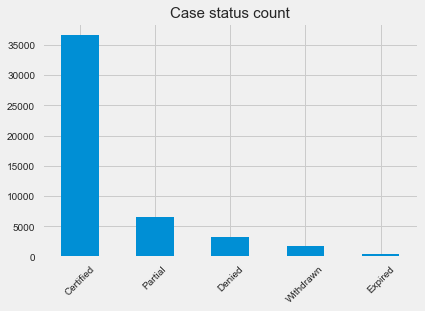

In [16]:
h2visas_df["case_status_sum"].value_counts().plot(kind='bar')
plt.title("Case status count", size=15)
plt.xticks(rotation=45)
plt.show()

`is_certified (True / False)` is a standardization of the `case_status` field.

In the following output we see that is_certified column contains partial and expired applications. Not certified also contains a few of them.

This part will need more research.

In [17]:
print(" -------------- is certified ------------ ")
print(h2visas_df["case_status_sum"][h2visas_df["is_certified"] == True].value_counts())
print(" \n-------------- is NOT certified --------- ")
print(h2visas_df["case_status_sum"][h2visas_df["is_certified"] == False].value_counts())

 -------------- is certified ------------ 
Certified    36340
Partial       6553
Expired        446
Name: case_status_sum, dtype: int64
 
-------------- is NOT certified --------- 
Denied       3290
Withdrawn    1805
Certified     331
Partial        42
Expired         6
Name: case_status_sum, dtype: int64


In [18]:
print("Number of NaN:")
print(h2visas_df[["case_status_sum","is_certified"]].isnull().sum())

Number of NaN:
case_status_sum    0
is_certified       0
dtype: int64


### 4.3 n_requested & n_certified

In [19]:
#Nulls
print("Number of NaN:")
print(h2visas_df[["n_requested","n_certified"]].isnull().sum())
h2visas_df[["n_requested","n_certified"]].describe(percentiles=[0.25,0.75,0.9,0.95,0.99])

Number of NaN:
n_requested    16134
n_certified        0
dtype: int64


,n_requested,n_certified
count,32679.000000,48813.000000
mean,16.138897,13.977649
std,31.068202,27.737889
min,0.000000,0.000000
25%,3.000000,2.000000
50%,7.000000,6.000000
75%,18.000000,15.000000
90%,40.000000,34.000000
95%,60.000000,52.000000
99%,135.000000,120.000000


In [20]:
h2visas_dfA = h2visas_df[h2visas_df['visa_type'] == 'H-2A']
h2visas_dfA.groupby('fy')['n_requested'].count()

fy
2011    2384
2012    2564
2013       0
2014       0
2015    2772
2016    6434
Name: n_requested, dtype: int64

In [21]:
h2visas_dfB = h2visas_df[h2visas_df['visa_type'] == 'H-2B']
h2visas_dfB.groupby('fy')['n_certified'].count()

fy
2011    4409
2012    4211
2013    4710
2014    5464
2015    6519
2016    4186
Name: n_certified, dtype: int64

Let's check the distribution for each kind of VISA

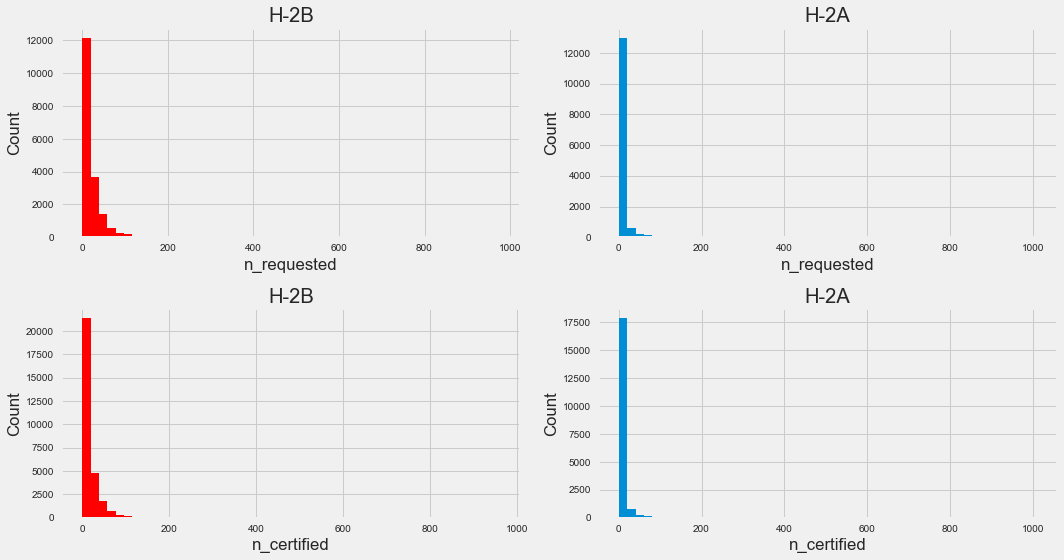

In [22]:
# show histogram of n_requested and n_certified under 150 for both types of visas capping at 200
fig = plt.figure(figsize=(15,8))
ax1 = plt.subplot2grid((2,2), (0, 0))
ax2 = plt.subplot2grid((2,2), (0, 1))
ax3 = plt.subplot2grid((2,2), (1, 0))
ax4 = plt.subplot2grid((2,2), (1, 1))
ax1.set(xlabel='n_requested' , ylabel='Count', title='H-2B')
ax2.set(xlabel='n_requested' , ylabel='Count', title='H-2A')
ax3.set(xlabel='n_certified' , ylabel='Count', title='H-2B')
ax4.set(xlabel='n_certified' , ylabel='Count', title='H-2A')
ax1.hist(h2visas_df.n_requested[h2visas_df.visa_type == 'H-2B'].dropna(),bins=50,color='r')
ax2.hist(h2visas_df.n_requested[h2visas_df.visa_type == 'H-2A'].dropna(),bins=50) 
ax3.hist(h2visas_df.n_certified[h2visas_df.visa_type == 'H-2B'],bins=50,color='r')
ax4.hist(h2visas_df.n_certified[h2visas_df.visa_type == 'H-2A'],bins=50) 
plt.tight_layout()
plt.show()

As we can see there are some outliers. Let's zoom in to where most of the data is:

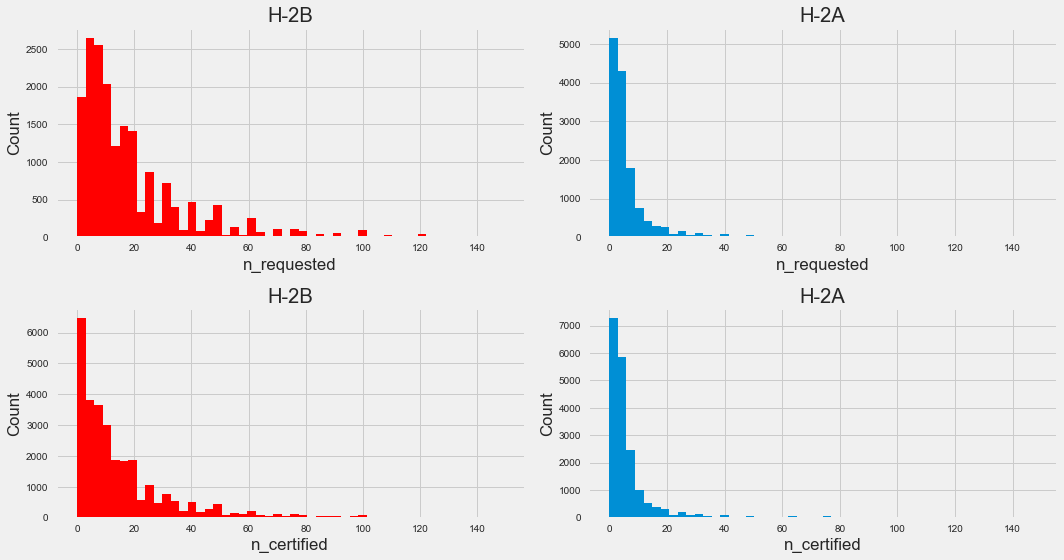

In [23]:
# show histogram of n_requested and n_certified under 150 for both types of visas
fig = plt.figure(figsize=(15,8))
ax1 = plt.subplot2grid((2,2), (0, 0))
ax2 = plt.subplot2grid((2,2), (0, 1))
ax3 = plt.subplot2grid((2,2), (1, 0))
ax4 = plt.subplot2grid((2,2), (1, 1))
ax1.set(xlabel='n_requested' , ylabel='Count', title='H-2B')
ax2.set(xlabel='n_requested' , ylabel='Count', title='H-2A')
ax3.set(xlabel='n_certified' , ylabel='Count', title='H-2B')
ax4.set(xlabel='n_certified' , ylabel='Count', title='H-2A')
ax1.hist(h2visas_df.n_requested[(h2visas_df.visa_type == 'H-2B') &
                                (h2visas_df.n_requested < 150)],bins=50,color='r')
ax2.hist(h2visas_df.n_requested[(h2visas_df.visa_type == 'H-2A') & 
                                (h2visas_df.n_requested < 150)],bins=50) 
ax3.hist(h2visas_df.n_certified[(h2visas_df.visa_type == 'H-2B') & 
                                (h2visas_df.n_certified < 150)],bins=50,color='r')
ax4.hist(h2visas_df.n_certified[(h2visas_df.visa_type == 'H-2A') &
                                (h2visas_df.n_certified < 150)],bins=50) 
plt.tight_layout()
plt.show()

There are a few outliers. Based on the histograms/descriptive stats from above I consider outliers those over 150 (less than 0.01% of the observations)

In [24]:
print('number of n_request over 150:')
print(len(h2visas_df[h2visas_df.n_requested > 150]))
print('number of n_certified over 150:')
print(len(h2visas_df[h2visas_df.n_certified > 150]))

number of n_request over 150:
222
number of n_certified over 150:
265


Let's check some of them. They seem legit.

In [25]:
h2visas_df[h2visas_df.n_requested > 150].head(3)

,case_no,visa_type,fy,last_event_date,case_status,n_requested,n_certified,is_certified,certification_begin_date,certification_end_date,...,employer_city,employer_address_1,employer_address_2,employer_postal_code,worksite_state,worksite_city,agent_name,organization_flag,is_duplicate,case_status_sum
189969,H-300-15075-754898,H-2A,2015,2015-04-06,DETERMINATION ISSUED - CERTIFICATION,400.0,400,True,2015-05-02,2015-07-24,...,WENATCHEE,PO BOX 2837,NaN,98801,WA,PASCO,NaN,NaN,True,Certified
190251,H-300-15084-548611,H-2A,2015,2015-04-14,DETERMINATION ISSUED - CERTIFICATION,200.0,200,True,2015-05-17,2015-11-05,...,ROYAL CITY,PO BOX 999,NaN,99357,WA,OTHELLO,NaN,NaN,True,Certified
190276,H-300-15077-436830,H-2A,2015,2015-04-14,DETERMINATION ISSUED - CERTIFICATION,250.0,250,True,2015-05-04,2015-11-14,...,SPRING HOPE,7840 OLD BAILEY HAWY,NaN,27882,NC,Vass,NaN,NaN,True,Certified


There are a few cases were n_certified is bigger than n_requested:

In [26]:
h2visas_df[['visa_type','fy','case_status_sum','n_requested','n_certified']][h2visas_df.n_certified > h2visas_df.n_requested]

,visa_type,fy,case_status_sum,n_requested,n_certified
199495,H-2B,2015,Partial,1.0,14
210837,H-2B,2016,Certified,8.0,84
211604,H-2B,2016,Certified,6.0,12
212263,H-2B,2016,Partial,1.0,8
212714,H-2B,2016,Certified,2.0,3


We drop this observations as there are very few and it won't affect our investigation:

In [27]:
h2visas_df.drop(h2visas_df[h2visas_df.n_certified > h2visas_df.n_requested].index,
                inplace=True)

In [28]:
print("What is the case status when n_requested is NaN? :")
h2visas_df.case_status_sum[h2visas_df.n_requested.isnull()].value_counts()

What is the case status when n_requested is NaN? :


Certified    11770
Partial       2015
Denied        1164
Withdrawn      750
Expired        435
Name: case_status_sum, dtype: int64

I can fix the ones that are certified because I know that all visas requested were granted, so I'll copy the value of `n_certified` to `n_requested`. 

In [29]:
new_values = h2visas_df.n_certified[(h2visas_df.case_status_sum == 'Certified') & (h2visas_df.n_requested.isnull())]
h2visas_df.loc[new_values.index,'n_requested']= new_values

I can't do nothing for the rest so I'll leave the as they are:

In [30]:
h2visas_df.case_status_sum[h2visas_df.n_requested.isnull()].value_counts()

Partial      2015
Denied       1164
Withdrawn     750
Expired       435
Name: case_status_sum, dtype: int64

Some values have `n_requested` iqual to 0:

In [31]:
h2visas_df['case_status_sum'][h2visas_df['n_requested'] == 0].value_counts()

Certified    331
Partial       30
Denied         6
Name: case_status_sum, dtype: int64

We can do the same thing as before and set `n_requested` to `n_certificed` when the case status is `Certified`. After we can get rid of the rest of the observations as they can be misnformative

In [32]:
new_values = h2visas_df.n_certified[(h2visas_df.case_status_sum == 'Certified') &
                                    (h2visas_df.n_requested == 0)]
h2visas_df.loc[new_values.index,'n_requested']= new_values
h2visas_df = h2visas_df[h2visas_df.n_requested != 0]

In [33]:
#Nulls
print("Number of NaN:")
print(h2visas_df[["n_requested","n_certified"]].isnull().sum())

Number of NaN:
n_requested    4364
n_certified       0
dtype: int64


The table below shows the sum of `n_certified` where `n_requested` is `NaN` per fiscal year

In [34]:
h2visas_df[h2visas_df["n_requested"].isnull()][['fy','n_certified']].groupby('fy').sum()

,n_certified
fy,
2011,0
2012,0
2013,32166
2014,35608
2016,1225


There are really high numbers for years 2013 and 2014. We'll take this into account in the analysis part of this notebook

### 4.4 last_event_date

First, let's convert all date columns to datetime

In [35]:
#convert to datetime
h2visas_df["last_event_date"] = pd.to_datetime(h2visas_df["last_event_date"])
h2visas_df["certification_begin_date"] = pd.to_datetime(h2visas_df["certification_begin_date"])
h2visas_df["certification_end_date"] = pd.to_datetime(h2visas_df["certification_end_date"])

Let's check `last_event_date` for nulls:

In [36]:
print ("Nulls last_event_date:")
vc = h2visas_df["visa_type"][h2visas_df["last_event_date"].isnull()].value_counts()
if len(vc)==0:
    print("No Nulls")
else:
    print(vc)

Nulls last_event_date:
No Nulls


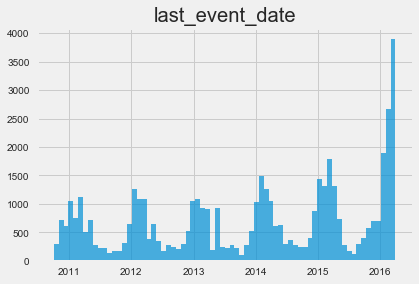

In [37]:
h2visas_df["last_event_date"].hist(bins=70,alpha=0.7)
plt.title('last_event_date')
plt.show()

### 4.5 certification_begin_date & certification_end_date

`cerfication_begin` dates and `certification_end` dates which are the actual date granted to an employer indicating when the need for the foreign workers to perform agricultural services or labor is expected to begin and end. 

In [38]:
print ("Nulls certification_begin_date:")
vc = h2visas_df["visa_type"][h2visas_df["certification_begin_date"].isnull()].value_counts()
if len(vc)==0:
    print("No Nulls")
else:
    print(vc)
    
print ("\nNulls certification_end_date:")
vc = h2visas_df["visa_type"][h2visas_df["certification_end_date"].isnull()].value_counts()
if len(vc)==0:
    print("No Nulls")
else:
    print(vc)
    
print("\nNumber of nulls for both values on the same row")
h2visas_df[(h2visas_df.certification_begin_date.isnull()) &
           (h2visas_df.certification_begin_date.isnull())].shape[0]

Nulls certification_begin_date:
H-2A    39
H-2B    23
Name: visa_type, dtype: int64

Nulls certification_end_date:
H-2A    43
H-2B    27
Name: visa_type, dtype: int64

Number of nulls for both values on the same row


62

As we can see most nulls are on the same rows. Let's get rid of them for the porpouse of this analysis as there are very few

In [39]:
h2visas_df.dropna(subset=['certification_begin_date','certification_end_date'],
                  inplace=True)

Let's check for outliers (year)

In [40]:
print(h2visas_df.certification_begin_date.dt.year.value_counts())
print(h2visas_df.certification_end_date.dt.year.value_counts())

2015    9909
2016    9490
2014    8162
2013    7001
2011    6673
2012    6650
2010     475
2001       2
2009       1
2031       1
2025       1
2017       1
Name: certification_begin_date, dtype: int64
2016    11123
2015     9369
2014     7862
2013     7039
2012     6640
2011     5526
2017      740
2018       35
2010       11
2019        8
2020        5
2025        2
2105        2
2104        1
2201        1
2102        1
2101        1
Name: certification_end_date, dtype: int64


We have very few of them. Let's get rid of them as this won't change the results of our analysis

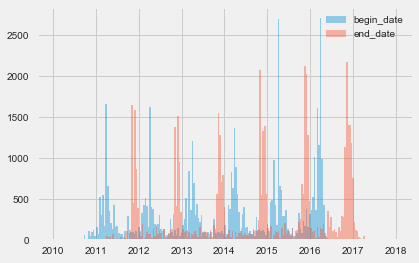

In [41]:
h2visas_df['certification_begin_date_year'] = h2visas_df.certification_begin_date.dt.year
h2visas_df['certification_end_date_year'] = h2visas_df.certification_end_date.dt.year
h2visas_df = h2visas_df[(h2visas_df.certification_begin_date_year > 2009) &
                        (h2visas_df.certification_begin_date_year < 2018)]
h2visas_df = h2visas_df[(h2visas_df.certification_end_date_year > 2009) & 
                        (h2visas_df.certification_end_date_year < 2018)]

h2visas_df["certification_begin_date"].hist(bins=200,alpha=0.4,label='begin_date')
h2visas_df["certification_end_date"].hist(bins=200,alpha=0.4,label='end_date')
plt.legend()
plt.show()

We can also check the time in between `certification_begin_date` and `certification_end_date` in days, add that feature as `certification_time`. We get rid of outliers (again, very few), and plot it:

In [42]:
date_aux = h2visas_df.loc[(h2visas_df['certification_begin_date'].notnull()) & 
                          (h2visas_df['certification_end_date'].notnull()),
                          ['certification_begin_date','certification_end_date']]

h2visas_df['certification_time']= ((date_aux.certification_end_date - date_aux.certification_begin_date) /
                                    np.timedelta64(1, 'D')).astype(int)

print(h2visas_df[['certification_time']].describe(percentiles=[0.01,0.25,0.75,0.9,0.95,0.99]))
h2visas_df = h2visas_df[(h2visas_df['certification_time'] > 0) & 
                       (h2visas_df['certification_time'] < 365)]

       certification_time
count        48305.000000
mean           245.079267
std             82.556976
min           -274.000000
1%              61.000000
25%            205.000000
50%            244.000000
75%            286.000000
90%            305.000000
95%            364.000000
99%            365.000000
max           2100.000000


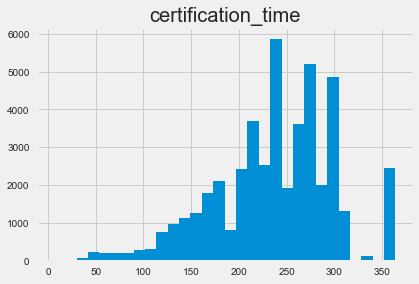

In [43]:
h2visas_df['certification_time'].hist(bins=30)
plt.title('certification_time')
plt.show()

### 4.6 job_title

In [44]:
print('Number of nulls:')
h2visas_df.fy.isnull().sum()

Number of nulls:


0

In [45]:
print('How many job titles?:')
len(h2visas_df.job_title.value_counts())

How many job titles?:


3904

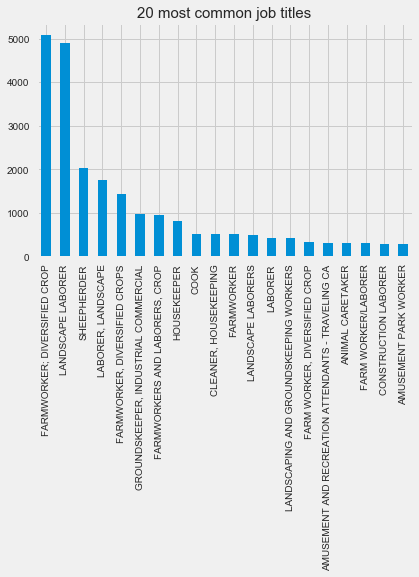

In [46]:
h2visas_df.job_title.value_counts()[:20].plot(kind='bar')
plt.title("20 most common job titles", size=15)
plt.show()

As we can see some names repeat themself. In the next interation of this notebook we could group jobs that have similar names

### 4.7 FY

In [47]:
print('Number of nulls:')
h2visas_df.fy.isnull().sum()

Number of nulls:


0

In [48]:
#counts
h2visas_df.fy.value_counts()

2016    10207
2015     8770
2014     7962
2013     6956
2011     6308
2012     6257
Name: fy, dtype: int64

### 4.8 Employer state

In [49]:
print('Number of nulls:')
h2visas_df.employer_state.isnull().sum()

Number of nulls:


23

We can impute this values by exctracting the state from the city. Let's check the cities for these entries:

In [50]:
cities = h2visas_df['employer_city'][h2visas_df.employer_state.isnull()].value_counts()
cities

WENATCHEE        3
STATE LINE RD    1
BURDETT          1
CHATHAM          1
SANFORD          1
FOREMOST         1
GALATI           1
HODGEVILLE       1
ROSE VALLEY      1
BLANCH NORTH     1
COALINGA         1
DELORAINE        1
SEATTLE          1
NORTH            1
Name: employer_city, dtype: int64

I'll use google maps API to get the state from the city, if I can't find it I'll leave it as `NaN`

In [51]:
import requests
dic_add = {} # to save what we find online
for city in cities.index:
    city = city.strip()
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address='+city+'NorthAmerica'
    try:        
        response = requests.get(url)
        resp_json_payload = response.json()
        dic_add[city]=(resp_json_payload['results'][0]['address_components'][2]['short_name'])
        if len(dic_add[city])>2:
            dic_add[city]=np.nan
    except:
        dic_add[city]=np.nan
          
#show results gotten from google maps
print("Results from quering google maps:")
for k,v in dic_add.items():
    print("Address: {0:20} Status: {1}".format(str(k),str(v)))

Results from quering google maps:
Address: WENATCHEE            Status: WA
Address: STATE LINE RD        Status: nan
Address: BURDETT              Status: nan
Address: CHATHAM              Status: nan
Address: SANFORD              Status: NC
Address: FOREMOST             Status: nan
Address: GALATI               Status: nan
Address: HODGEVILLE           Status: nan
Address: ROSE VALLEY          Status: PA
Address: BLANCH NORTH         Status: nan
Address: COALINGA             Status: CA
Address: DELORAINE            Status: nan
Address: SEATTLE              Status: WA
Address: NORTH                Status: nan


Let's use this results

In [52]:
print("Fixing .....")
for i in h2visas_df['employer_city'][h2visas_df.employer_state.isnull()].dropna().index:
    h2visas_df.loc[i,('employer_state')]=dic_add[str((h2visas_df.loc[i]['employer_city']).strip())]
print("... done fixing")
print("All fixed but: ")
h2visas_df.employer_state.isnull().sum()

Fixing .....
... done fixing
All fixed but: 


16

Let's do a sanity check on the names of the states

In [53]:
# valid names
us_states = ['AL','AK','AZ','AR','CA','CO','CT','DC','DE','FL','GA','GU','HI','ID','IL','IN','IA','KS','KY','LA','ME','MD','MA','MI',
             'MN','MS','MO','MP','MT','NE','NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA','PR','RI','SC','SD','TN','TX','UT',
             'VI','VT','VA','WA','WV','WI','WY']
can_states = ['AB','BC','MB','NB','NL','NT','NS','NU','ON','PE','QC','SK','YT']

In [54]:
# what states are wrong?
wrong_states = []
for state in h2visas_df.employer_state.value_counts().index:
    if (state not in us_states) and (state not in can_states) and (state not in wrong_states):
        wrong_states.append(state)
print('Non existent states:')
wrong_states

Non existent states:


[]

All state names are valid.

### 5. Feature selection

The data is now ready for analysis. Let's select the column we are interested in for this analysis

In [55]:
h2visas_df.columns

Index(['case_no', 'visa_type', 'fy', 'last_event_date', 'case_status',
       'n_requested', 'n_certified', 'is_certified',
       'certification_begin_date', 'certification_end_date', 'job_title',
       'employer_name', 'employer_state', 'employer_city',
       'employer_address_1', 'employer_address_2', 'employer_postal_code',
       'worksite_state', 'worksite_city', 'agent_name', 'organization_flag',
       'is_duplicate', 'case_status_sum', 'certification_begin_date_year',
       'certification_end_date_year', 'certification_time'],
      dtype='object')

In [56]:
h2visas_df.drop(['is_duplicate','agent_name','worksite_city','employer_address_2','case_status','organization_flag'], axis=1, inplace=True)

case_no                             0
visa_type                           0
fy                                  0
last_event_date                     0
n_requested                      4143
n_certified                         0
is_certified                        0
certification_begin_date            0
certification_end_date              0
job_title                          40
employer_name                      20
employer_state                     16
employer_city                      15
employer_address_1                 27
employer_postal_code              100
worksite_state                    398
case_status_sum                     0
certification_begin_date_year       0
certification_end_date_year         0
certification_time                  0
dtype: int64


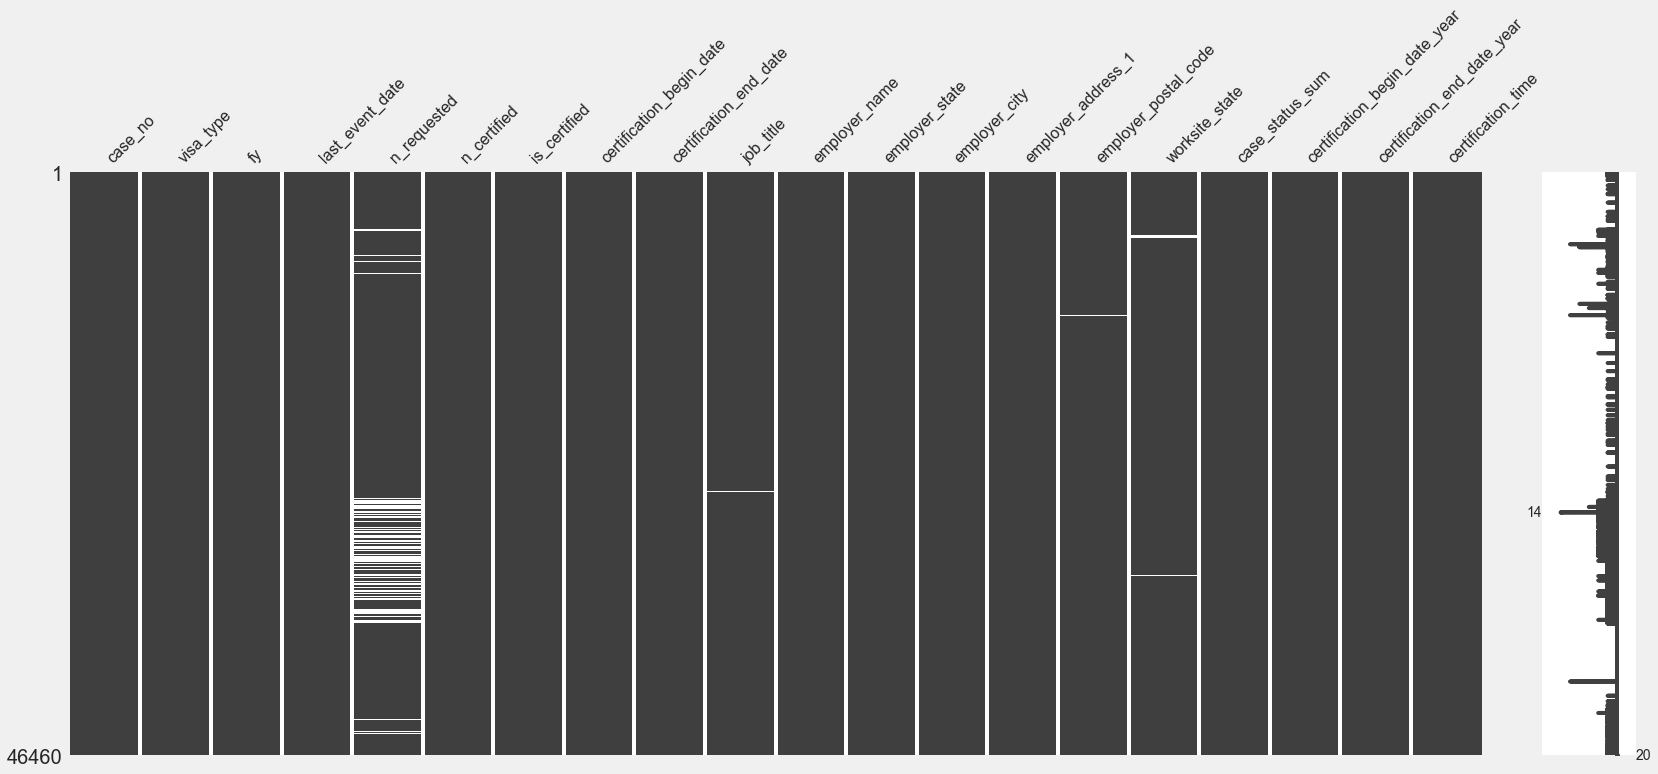

In [57]:
print(h2visas_df.isnull().sum())
msno.matrix(h2visas_df)

I could also delete the few rows I have with nulls but they don't bother me right now so I'll leave that for now

## 6. Analysis
Stats for year 2016 are shown in the quantitative measures but not plotted because we don't have a complete fiscal year

In [58]:
# create new column with the key for vincent maps
states = {'AK': 'Alaska','AL': 'Alabama','AR': 'Arkansas','AS': 'American Samoa','AZ': 'Arizona','CA': 'California',
        'CO': 'Colorado','CT': 'Connecticut','DC': 'District of Columbia','DE': 'Delaware','FL': 'Florida','GA': 'Georgia',
        'GU': 'Guam','HI': 'Hawaii','IA': 'Iowa','ID': 'Idaho','IL': 'Illinois','IN': 'Indiana','KS': 'Kansas','KY': 'Kentucky',
        'LA': 'Louisiana','MA': 'Massachusetts','MD': 'Maryland','ME': 'Maine','MI': 'Michigan','MN': 'Minnesota',
        'MO': 'Missouri','MP': 'Northern Mariana Islands','MS': 'Mississippi','MT': 'Montana','NA': 'National',
        'NC': 'North Carolina','ND': 'North Dakota','NE': 'Nebraska','NH': 'New Hampshire','NJ': 'New Jersey','NM': 'New Mexico',
        'NV': 'Nevada','NY': 'New York','OH': 'Ohio','OK': 'Oklahoma','OR': 'Oregon','PA': 'Pennsylvania','PR': 'Puerto Rico',
        'RI': 'Rhode Island','SC': 'South Carolina','SD': 'South Dakota','TN': 'Tennessee','TX': 'Texas','UT': 'Utah',
        'VA': 'Virginia','VI': 'Virgin Islands','VT': 'Vermont', 'WA': 'Washington','WI': 'Wisconsin','WV': 'West Virginia',
        'WY': 'Wyoming','AB': 'Alberta','BC': 'British Columbia','MB': 'Manitoba','NB': 'New Brunswick','NL': 'Newfoundland and Labrador',
        'NT': 'Northwest Territories','NS': 'Nova Scotia','NU': 'Nunavut','ON': 'Ontario','PE': 'Prince Edward Island',
        'QC': 'Quebec','SK': 'Saskatchewan','YT': 'Yukon'}

### 6.1) How application status have change over time

In [59]:
h2visas_df['visa_type'].value_counts()

H-2B    28809
H-2A    17651
Name: visa_type, dtype: int64

In [60]:
h2visas_dfB = h2visas_df[h2visas_df['visa_type'] == 'H-2B']
h2visas_dfA = h2visas_df[h2visas_df['visa_type'] == 'H-2A']


apgpA = h2visas_dfA.groupby(['fy','case_status_sum'])['fy'].count()
to_plotA = apgpA.unstack(level=1,fill_value=0)

apgpB= h2visas_dfB.groupby(['fy','case_status_sum'])['fy'].count()
to_plotB = apgpB.unstack(level=1,fill_value=0)

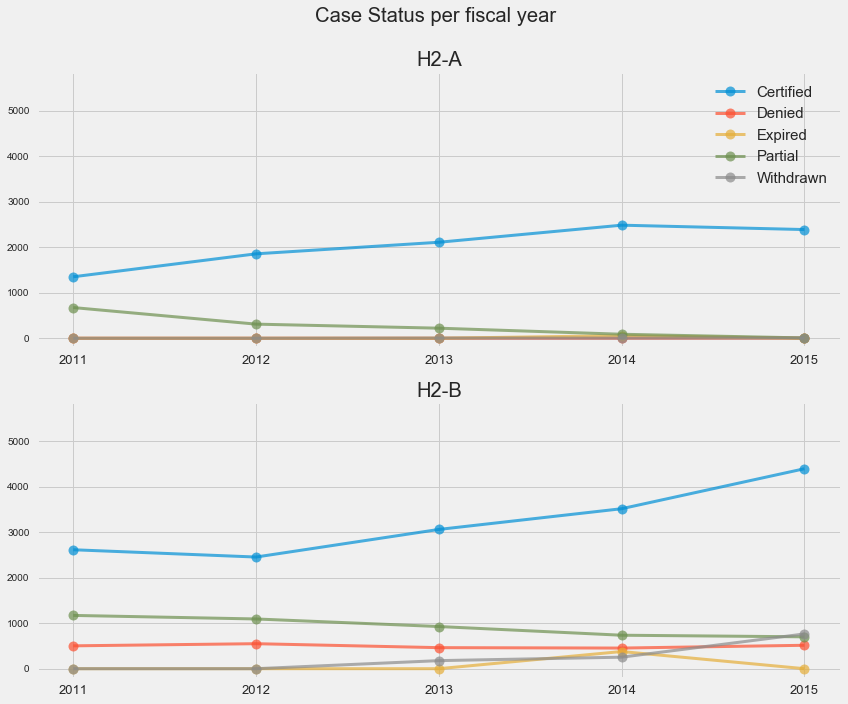

In [61]:
fig = plt.figure(figsize=(12,10))

ymax = np.max([np.max(np.max(to_plotA)),np.max(np.max(to_plotB))])

ax1 = plt.subplot2grid((2,1), (0, 0))
ax1.set(label='Year', title='Case Status per fiscal year \n\nH2-A',xticks=(np.arange(2011, 2016, 1.0)))
ax1.ticklabel_format(useOffset=False)
ax1.plot(to_plotA.loc[:2015],linestyle='-', marker='o',linewidth=3,markersize=10,alpha=0.7)
ax1.legend(apgpA.index.levels[1],loc=0,prop={'size':15})
ax1.set_ylim([-200,ymax])
ax1.xaxis.set_tick_params(labelsize=13)

ax2 = plt.subplot2grid((2,1), (1, 0))
ax2.set(title='H2-B',xticks=(np.arange(2011, 2016, 1.0)))
ax2.ticklabel_format(useOffset=False)
ax2.plot(to_plotB.loc[:2015],linestyle='-', marker='o',linewidth=3,markersize=10,alpha=0.7)
ax2.set_ylim([-200,ymax])
ax2.xaxis.set_tick_params(labelsize=13)

plt.tight_layout()
plt.show()

### 6.2) How have the number of approved workers has changed  over time? and the number of employers?

In [62]:
h2visas_df.groupby(['visa_type','fy'])['n_certified'].sum().loc['H-2A'].loc[:2015]

fy
2011    12595
2012    14298
2013    17429
2014    20096
2015    22205
Name: n_certified, dtype: int64

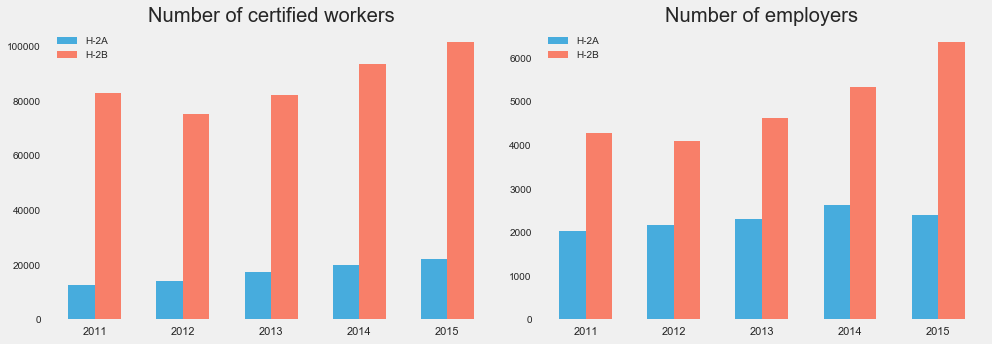

In [157]:
fig = plt.figure(figsize=(14,5))

to_plotA = h2visas_df.groupby(['visa_type','fy'])['n_certified'].sum().loc['H-2A'].loc[:2015]
to_plotB= h2visas_df.groupby(['visa_type','fy'])['n_certified'].sum().loc['H-2B'].loc[:2015]

width = 0.30       # the width of the bars


ax1 = plt.subplot2grid((1,2), (0, 0))
ax1.bar(to_plotA.index,to_plotA.values, width, alpha=0.7,label='H-2A')
ax1.bar(to_plotB.index+width,to_plotB.values, width, alpha=0.7,label='H-2B')
ax1.set_xticks(to_plotB.index+width/2)
ax1.set_xticklabels(to_plotB.index)
ax1.set(title='Number of certified workers')
ax1.xaxis.set_tick_params(labelsize=11)
ax1.yaxis.grid(False)
ax1.xaxis.grid(False)
ax1.legend(loc=2)



h2visas_dfB = h2visas_df[h2visas_df['visa_type'] == 'H-2B']
h2visas_dfA = h2visas_df[h2visas_df['visa_type'] == 'H-2A']

to_plotA = h2visas_dfA.groupby("fy")['employer_name'].count().loc[:2015]
to_plotB = h2visas_dfB.groupby("fy")['employer_name'].count().loc[:2015]

width = 0.30       # the width of the bars

ax2 = plt.subplot2grid((1,2), (0, 1))
ax2.bar(to_plotA.index,to_plotA.values, width, alpha=0.7,label='H-2A')
ax2.bar(to_plotB.index+width,to_plotB.values, width, alpha=0.7,label='H-2B')
ax2.set_xticks(to_plotB.index+width/2)
ax2.set_xticklabels(to_plotB.index)
ax2.set(title='Number of employers')
ax2.xaxis.set_tick_params(labelsize=11)
ax2.yaxis.grid(False)
ax2.xaxis.grid(False)
ax2.legend(loc=2)

plt.tight_layout()
plt.show()


### 6.3) Which states request the most visas and how has this changed over time?

Let's check the top 10 states and plot how the applications of these states have changed over time

In [64]:
h2visas_dfB = h2visas_df[h2visas_df['visa_type'] == 'H-2B']
h2visas_dfA = h2visas_df[h2visas_df['visa_type'] == 'H-2A']

top5_statesA = h2visas_dfA.employer_state.value_counts().index[:5]
top5_statesB = h2visas_dfB.employer_state.value_counts().index[:5]

apgpA = h2visas_dfA[h2visas_dfA["employer_state"].isin(top5_statesA)].groupby(['fy','employer_state'])['fy'].count()
to_plotA = apgpA.unstack(level=1,fill_value=0)

apgpB = h2visas_dfB[h2visas_dfB["employer_state"].isin(top5_statesB)].groupby(['fy','employer_state'])['fy'].count()
to_plotB = apgpB.unstack(level=1,fill_value=0)

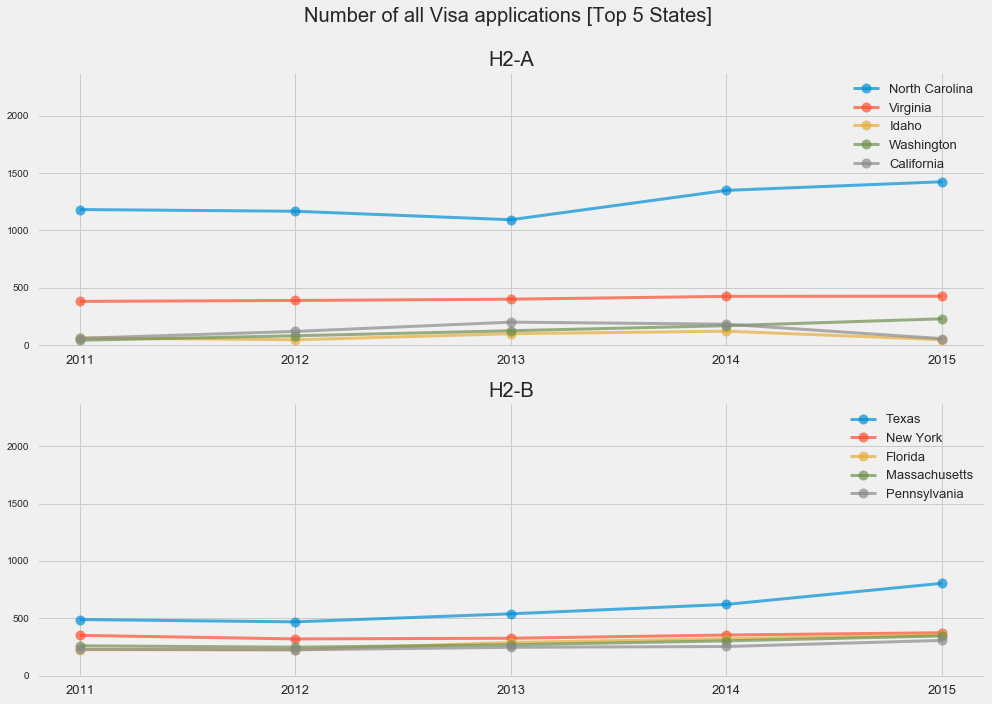

In [223]:
fig = plt.figure(figsize=(14,10))


ymax = np.max([np.max(np.max(to_plot)),np.max(np.max(to_plot))])

ax1 = plt.subplot2grid((2,1), (0, 0))
ax1.set(title='Number of all Visa applications [Top 5 States] \n\nH2-A',xticks=(np.arange(2011, 2016, 1.0)))
for st in top5_statesA:
    ax1.plot(to_plotA.loc[:2015][st],linestyle='-', marker='o',linewidth=3,markersize=10,alpha=0.7,label=states[st])
    
ax1.set_ylim([-20,ymax+800])
ax1.xaxis.set_tick_params(labelsize=13)
ax1.legend(fontsize=13)


ax2 = plt.subplot2grid((2,1), (1, 0))
ax2.set(title='H2-B',xticks=(np.arange(2011, 2016, 1.0)))
for st in top5_statesB:
    ax2.plot(to_plotB.loc[:2015][st],linestyle='-', marker='o',linewidth=3,markersize=10,alpha=0.7,label=states[st])
    
ax2.set_ylim([-20,ymax+800])
ax2.xaxis.set_tick_params(labelsize=13)
ax2.legend(fontsize=13)


plt.tight_layout()
plt.show()

### 6.4) Number of approved Visas per state in 2015 

In [112]:
h2visas2015 = h2visas_df[h2visas_df['fy']==2015].copy()

h2visas2015.dropna(subset=["employer_state"], axis=0, inplace=True) # only 16
h2visas_dfB = h2visas2015[h2visas2015['visa_type'] == 'H-2B']
h2visas_dfA = h2visas2015[h2visas2015['visa_type'] == 'H-2A']

df_aux = h2visas_dfA.groupby("employer_state")['n_certified'].sum()
map_valuesA = df_aux.values
map_codesA = df_aux.index

df_aux = h2visas_dfB.groupby("employer_state")['n_certified'].sum()
map_valuesB = df_aux.values
map_codesB = df_aux.index

In [131]:
#scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
#            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

colorscale=[[0.3333333333333333, 'rgb(253,174,97)'], [0.4444444444444444, 'rgb(254,224,144)'],
            [0.5555555555555556, 'rgb(224,243,248)'], [0.6666666666666666, 'rgb(171,217,233)'],
            [0.7777777777777778, 'rgb(116,173,209)'], [0.8888888888888888, 'rgb(69,117,180)']]
    

dataA = [ dict(
        type='choropleth',
        colorscale = colorscale,
        autocolorscale = False,
        locations = map_codesA,
        z = map_valuesA,
        locationmode = 'USA-states',
        #text = map_values,
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            )
        ),
        colorbar = dict(
            title = ""
        )
    ) ]

dataB = [ dict(
        type='choropleth',
        colorscale = colorscale,
        autocolorscale = False,
        locations = map_codesB,
        z = map_valuesB,
        locationmode = 'USA-states',
        #text = map_valuesB,
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            )
        ),
        colorbar = dict(
            title = ""
        )
    ) ]

layoutA = dict(
        title = '2015 Number of certified H-2A Visas',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )

layoutB = dict(
        title = '2015 Number of certified H-2B Visas',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )

In [163]:
import plotly
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)

fig = dict( data=dataA, layout=layoutA)
url = plotly.offline.iplot( fig, filename='VA-cloropleth-map' )

fig = dict( data=dataB, layout=layoutB)
url = plotly.offline.iplot( fig, filename='VB-cloropleth-map' )

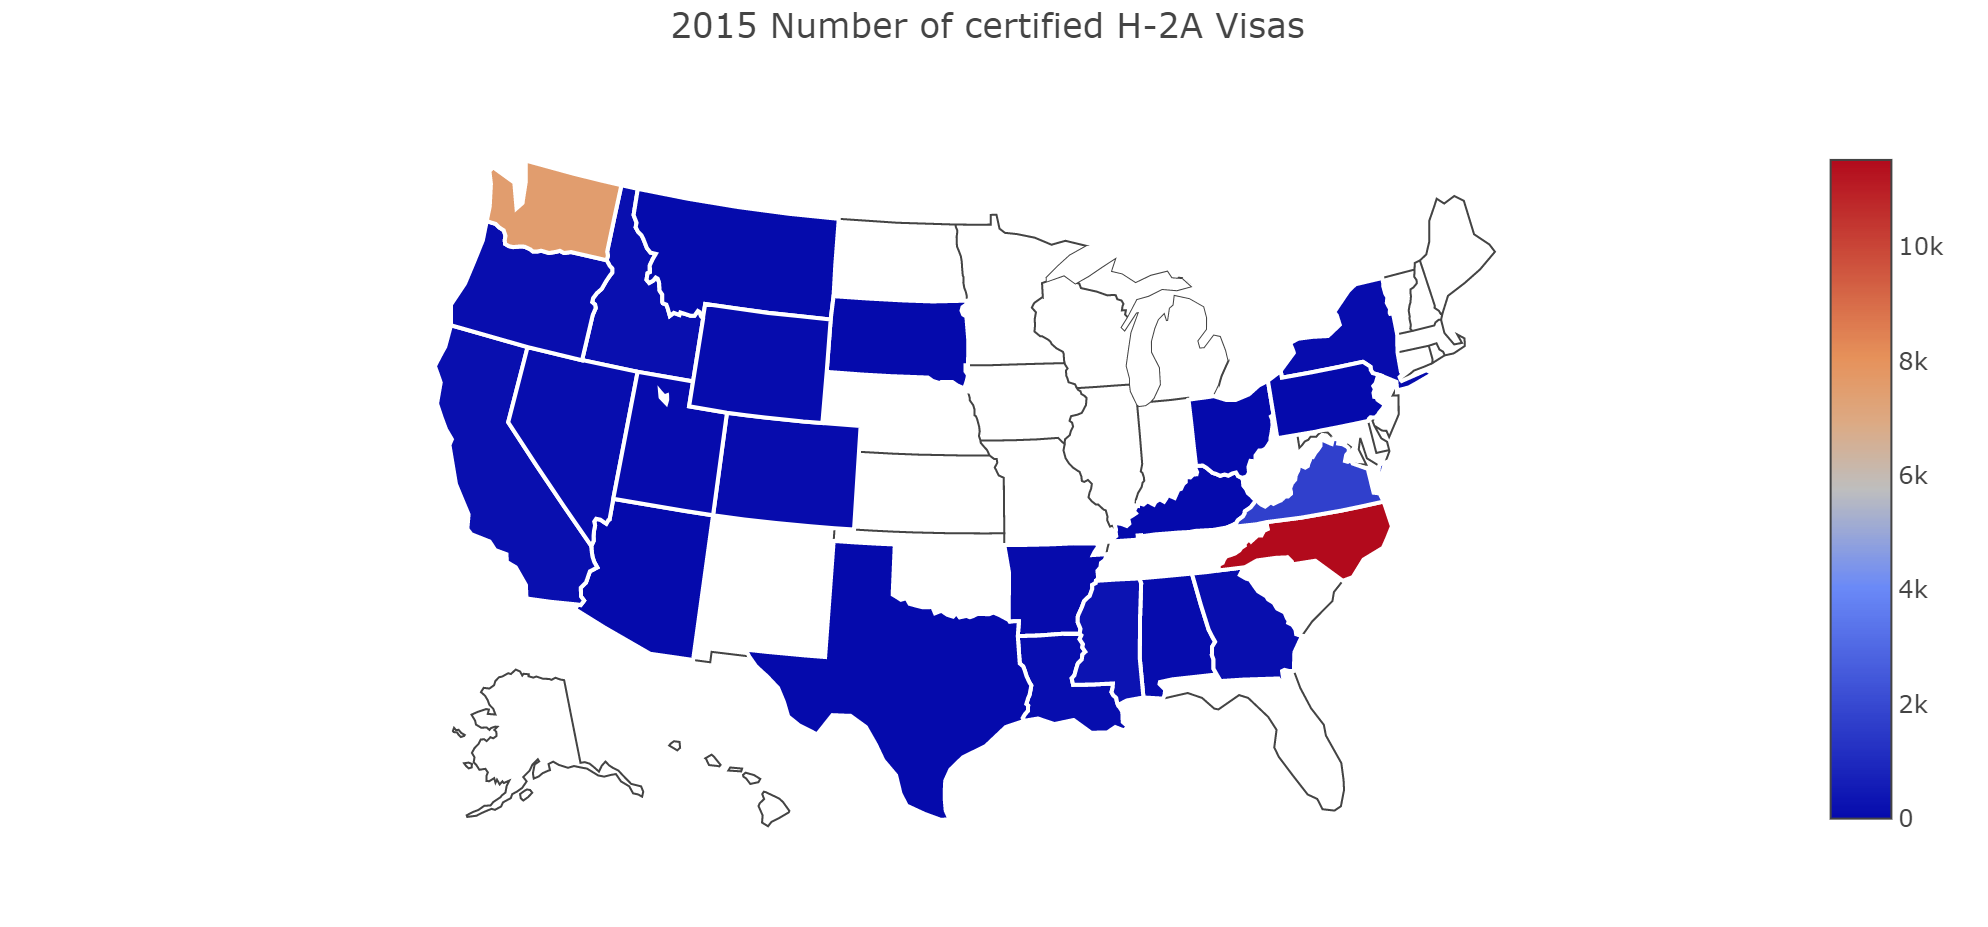

In [161]:
from IPython.display import Image
Image(filename='./maps/mapA.png')

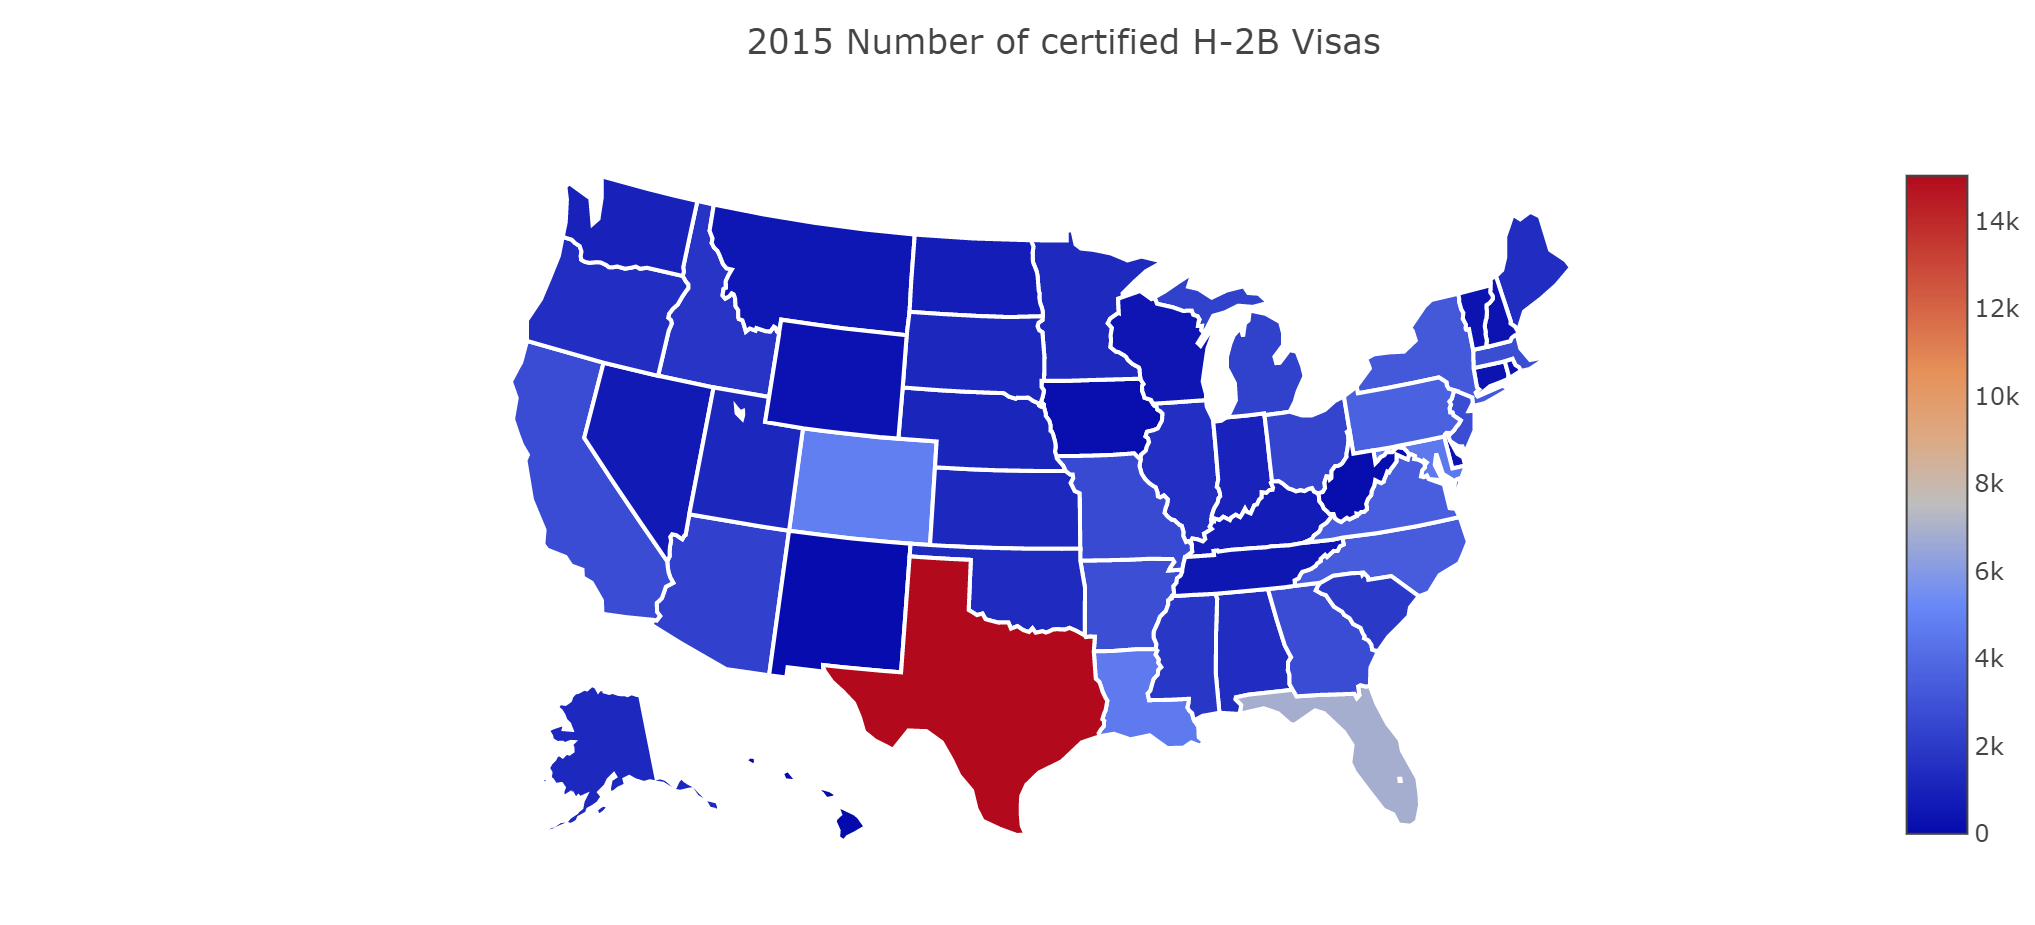

In [162]:
from IPython.display import Image
Image(filename='./maps/mapB.png')